# conjugate gradient solver

An exploration of the conjugate gradient solver. <br>
Considering the particular problem of getting reflectivity from a seismic trace, given the wavelet.

This was the topic of a previous tutorial which used the numpy and scipy matrix solvers.  This notebook solves same problem the conjugate gradient method and compares the result to the matrix solver results.

We'll be working on a model, so we know the correct answer from the start.


In [1]:
#import some basics and print the versions
import sys
print "sys.version=",sys.version
import numpy as np
import scipy as sp
print "np.__version__=",np.__version__
import matplotlib.pyplot as plt
%matplotlib inline


sys.version= 2.7.13 |Anaconda 2.5.0 (x86_64)| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
np.__version__= 1.9.3


## Some helpful functions

These are some functions we will use later. I'm defining them up-front so that we can talk about the maths without too much code getting in the way. It's probably best to ignore these for now, but when we get to them, you might want to come back here to understand what they do.

In [2]:
from scipy import linalg as spla

def convmtx(h, n):
    """
    Equivalent of MATLAB's convmtx function, http://www.mathworks.com/help/signal/ref/convmtx.html.
    
    Makes the convolution matrix, C. The product C.x is the convolution of h and x.
    
    Args
        h (ndarray): a 1D array, the kernel.
        n (int): the number of rows to make.
        
    Returns
        ndarray. Size m+n-1
    """
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return spla.toeplitz(col_1, row_1)
mymatrix=convmtx(np.array([1, -1]), 5)
print "simple test of convmtx"
print "matrix to convolve [1,-1] on a 5 point vector=",convmtx([1, -1], 5)

simple test of convmtx
matrix to convolve [1,-1] on a 5 point vector= [[ 1. -1.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  1. -1.]]


## Construct the model m

We start with the slightly odd-seeming number of samples 51. This is because when we calculate the impedance contrasts (reflectivities), we'll lose a sample. Since I'd like 50 samples in the final reflectivity model `m`, we have to start with 50 + 1 samples in the impedance model.


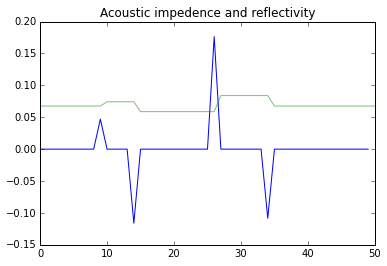

m.size= 50


In [3]:
# Impedance, imp     VP    RHO
imp = np.ones(51) * 2550 * 2650
imp[10:15] =        2700 * 2750
imp[15:27] =        2400 * 2450
imp[27:35] =        2800 * 3000

# really want reflectivity, so compute and plot it.
m = (imp[1:] - imp[:-1]) / (imp[1:] + imp[:-1])

fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Acoustic impedence and reflectivity')

plt.plot(m)

# We can plot the impedance too, scaled to fit on this plot, so we
# can see how the interface property relates to the rock property.
plt.plot(imp/1e8, alpha=0.5)
plt.show()
print 'm.size=',m.size


Notice that we lost a sample: now there are only 50 samples. This is what we wanted.

## Forward operator: convolution with wavelet

Now we make the kernel matrix *G*, which represents convolution.


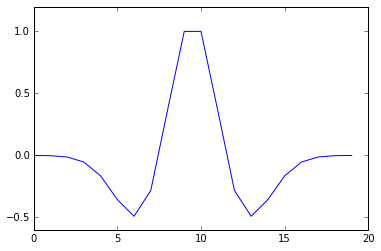

In [4]:
from scipy.signal import ricker
wavelet = ricker(points=20, a=2)

# normalize the wavelet amplitude to 1 so that the amplitude relates directly to the reflectivity.

wavelet /= np.amax(wavelet)

plt.plot(wavelet)
plt.show()


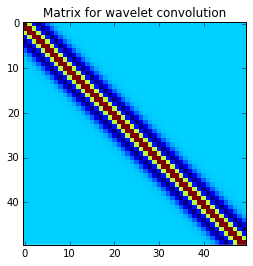

In [5]:

# Make G.
G = convmtx(wavelet, m.size)[:, 10:60]
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Matrix for wavelet convolution')


plt.imshow(G, cmap='jet', interpolation='none')
plt.savefig('figure_convolution_matrix.png', dpi=200, facecolor=fig.get_facecolor())


plt.show()


## Forward model the data d

Now we can perform the forward problem: computing the data. We use the formulation

$$ \mathbf{d} = \mathbf{Gm} $$

Note that this equation is often rearranged and written $$ \mathbf{Ax} = \mathbf{b} $$ in linear algebra textbooks and in other tutorials, etc. Just in case you're looking for more examples. In that case, **A** is analogous to **G**, and **b** to **d**, and we're solving for **x** not **m**. All just notation &mdash; we can of course call things whatever we want.

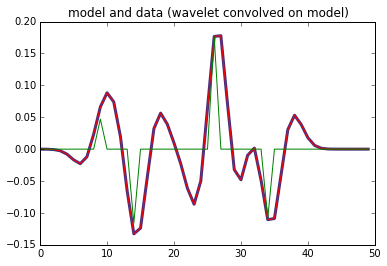

In [6]:
# plot trace computed with matrix and numpy convolve.  
# They should be identical.  Then compute d (the data) using the G matrix
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('model and data (wavelet convolved on model)')


plt.plot(np.convolve(wavelet, m, mode='same'), c='#462f7c', lw=3)
plt.plot(np.dot(G , m), 'red')
plt.plot(m)
plt.savefig('figure_model_data.png', dpi=200, facecolor=fig.get_facecolor())
plt.show()

d = np.dot(G , m )

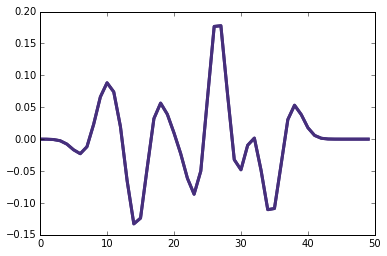

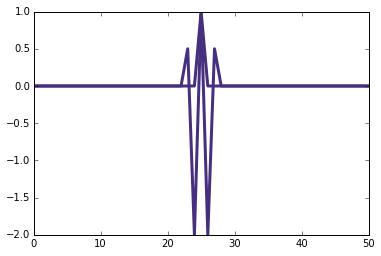

In [7]:
# define the Claerbout style convolution function that has switches
# for add and adj
def adj_null(adj, add, x, y):
    if add:
        return
    if adj:
        x[:]=0
    else:
        y[:]=0
    return
# validate adj_null function (turned off)
if False:
    x=np.zeros(20)
    y=np.zeros(20)
    x[x.size/2]=1.0
    y[y.size/2]=1.0
    print 'x=',x
    print 'y=',y
    adj_null(True,True,x,y)
    print 'x=',x
    print 'y=',y

def convolve(adj,add,x,y,wavelet,lag_t0):
    adj_null(adj, add, x, y)
    for iwavelet in range(wavelet.size):
        shift=iwavelet-lag_t0
        if adj:
            if shift==0:
                x+=y*wavelet[iwavelet]
            elif shift >0:
                x[:-shift]+=y[shift:]*wavelet[iwavelet]
            else:
                x[-shift:]+=y[:shift]*wavelet[iwavelet]
  
        else:
            if shift==0:
                y+=x*wavelet[iwavelet]
            elif shift >0:
                y[shift:]+=x[:-shift]*wavelet[iwavelet]
            else:
                y[:shift]+=x[-shift:]*wavelet[iwavelet]

                
# convolve the ricker wavelet using numpy.convolve, G matrix, and 
# the new convolve function.  Plot them all on the same plot to see 
# if they look the same.

wavelet_lag_t0=wavelet.size/2-1
# make y array same size as m array (previously it was a short test array)
y=np.zeros(m.size)

convolve(False,False,m,y, wavelet, wavelet_lag_t0)
plt.plot(y, c='#462f7c', lw=3)
plt.plot(np.dot(G , m), 'red')
plt.plot(np.convolve(wavelet, m, mode='same'), c='#462f7c', lw=3)

plt.show()

# test the adjoint switch.  The adjoint should reverse the wavelet.
# make an asymetrical wavelet.
wavelet1=np.array([0.0,0.0,1.0,-2.0,.50])
wavelet1_lag_t0=2
y=np.zeros(51)
y[y.size/2]=1.0
x=np.zeros(y.size)
plt.plot(np.convolve(wavelet1, y, mode='same'), c='#462f7c', lw=3)
# this should make x array that has wavelet reversed from previous
convolve(True,False,x,y, wavelet1, wavelet1_lag_t0)
plt.plot(x, c='#462f7c', lw=3)     

plt.show()



In [8]:
# test adj is working correctly
# previous visual tests looks good.  The asymetric wavelet is flipped.
# another test is Claerbout's dot using random x and y vetors, see if
# <convolve(x),y> = <x , convolveadj(y)>
# first just print some random numbers to test understanding of function
print "5 random numbers=",np.random.rand(5)
print "5 more random numbers=",np.random.rand(5)

# now run claerbout's dot test
x=np.random.rand(51)
y=np.random.rand(51)
wavelet1=np.array([0.0,0.0,1.0,-2.0,.50])
convolvex=np.random.rand(51)
convolveadjy=np.random.rand(51)
convolve(False,False,x           ,convolvex, wavelet1, 2)
convolve(True ,False,convolveadjy,y        , wavelet1, 2)
print '<convolve(x),y> =',np.dot(convolvex,y), '<x , convolveadj(y)>=',np.dot(x,convolveadjy)
print 'diff=',np.dot(convolvex,y)-np.dot(x,convolveadjy)



5 random numbers= [ 0.54939863  0.93047115  0.76617735  0.70439986  0.48704418]
5 more random numbers= [ 0.62892815  0.43912006  0.83422839  0.51744708  0.89101768]
<convolve(x),y> = -3.75951386881 <x , convolveadj(y)>= -3.75951386881
diff= 4.4408920985e-16


In [9]:
# recreate results from previous tutorial.
# solve for m_est and test the solution (compute d_pred from m_est)
m_est = np.linalg.lstsq(G, d,rcond=.2)[0]
d_pred = np.dot(G , m_est )

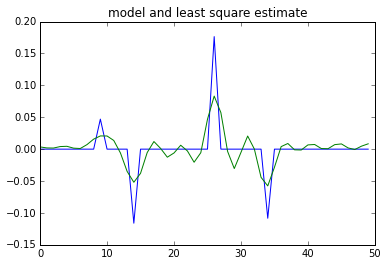

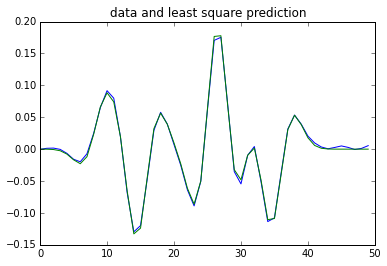

In [10]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('model and least square estimate')

plt.plot(m)
plt.plot(m_est)
plt.savefig('figure_model_lstsq_est.png', dpi=200, facecolor=fig.get_facecolor())
plt.show()


fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('data and least square prediction')

plt.plot(d_pred)
plt.plot(d)
plt.savefig('figure_data_lstsq_pred.png', dpi=200, facecolor=fig.get_facecolor())

plt.show()



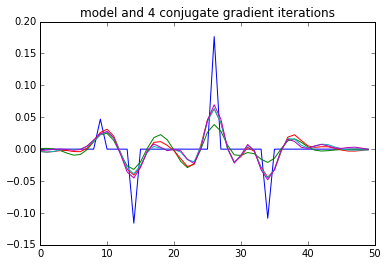

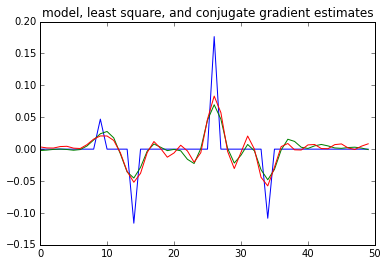

In [11]:
# estimate model using conjugate gradient method

# first simpify gou's pseudo code removing right proconditioner, ie set R=identity
# this makes z the same as deltax.
# x=0
# r=d - F*x
# s=0
# beta=0
# iterate (
#    deltax = F'*r
#    if not first iteration beta=<deltax,deltax>/gamma
#    gamma=<deltax,deltax>
#    s=deltax + beta*s
#    deltar= F*s
#    alpha=gamma/<deltar,deltar>
#    x=x + alpha*s
#    r=r - alpha*deltar
#)
# Adopt the pseudo code variables to solve our problem
# x - m_est the model we are trying to estimate
# d - d the seimsic trace
# F - the convolution operator

# x=0
x=np.zeros(d.size)
# r=d - F*x
F_x=np.zeros(d.size)
convolve(False,False,x,F_x, wavelet, wavelet_lag_t0)
r=d - F_x
beta=0.0
# iterate
niter=4
# allocate work arrays
deltax=np.zeros(d.size)
deltar=np.zeros(d.size)
s=np.zeros(d.size)
# label the plots
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('model and %d conjugate gradient iterations'%niter)

# plot the answer (each iteration will overplot the answer)
plt.plot(m)
for iter in range(niter):
    # deltax= F'*r
    convolve(True,False,deltax,r,wavelet,wavelet_lag_t0)
    # if not first iteration beta=<deltax,deltax>/gamma
    if iter!=0:
        beta=np.dot(deltax,deltax)
    #    gamma=<deltax,deltax>
    gamma=np.dot(deltax,deltax)
    #    s=deltax + beta*s
    s=deltax + beta*s
    #    deltar= F*s
    convolve(False,False,s,deltar,wavelet,wavelet_lag_t0)
    #    alpha=gamma/<deltar,deltar>
    alpha=gamma/np.dot(deltar,deltar)
    #    x=x + alpha*s
    x=x + alpha*s
    #    r=r - alpha*deltar
    r=r - alpha*deltar
    plt.plot(x)

m_cgest=x
#show the result
plt.savefig('figure_cg_est_iter.png', dpi=200, facecolor=fig.get_facecolor())

plt.show()

if False:
    plt.plot(x)
    plt.show()
    plt.plot(m_est)
    plt.show()

fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('model, least square, and conjugate gradient estimates')

plt.plot(m)
plt.plot(m_cgest)
plt.plot(m_est)
plt.savefig('figure_model_lstsq_cg_est.png', dpi=200, facecolor=fig.get_facecolor())

plt.show()



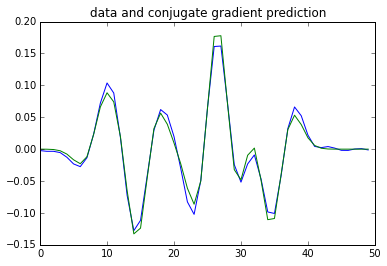

In [12]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('data and conjugate gradient prediction')
d_cgpred=np.zeros(m_cgest.size)
convolve(False,False,m_cgest,d_cgpred,wavelet,wavelet_lag_t0)
plt.plot(d_cgpred)
plt.plot(d)
plt.savefig('figure_data_cg_pred.png', dpi=200, facecolor=fig.get_facecolor())


plt.show()



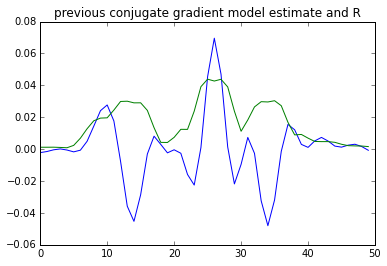

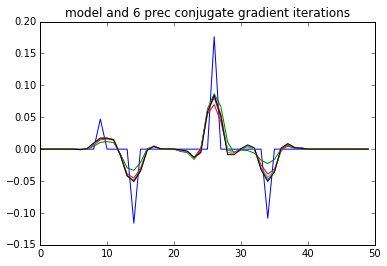

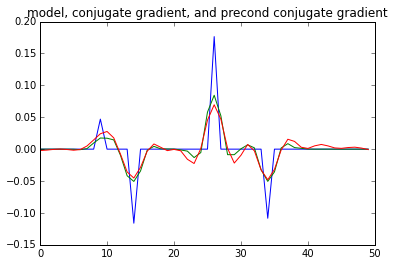

In [13]:
# estimate model using preconditioned conjugate gradient method

# I will use the previous unconditioned results and attempt to concentrate 
# amplitude in the locations that already have large amplitude.  The 
# preconditioner is to scale by sqrt(previous result smoothed amplitude^2).
# this will make the large amplitude in the estimated model larger.

# compute R.  Make plot comparint it to previous result (m_cgest)
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('previous conjugate gradient model estimate and R')
R=np.sqrt(np.convolve(np.ones(5)/5.0, m_cgest*m_cgest, mode='same'))
plt.plot(m_cgest)
plt.plot(R)
plt.savefig('figure_cg_est_R.png', dpi=200, facecolor=fig.get_facecolor())


plt.show()
# x=0
# r=d - F*x
# s=0
# beta=0
# iterate (
#    deltax = F'*r
#    z=R * R' * deltax
#    if not first iteration beta=<deltax,z>/gamma
#    gamma=<deltax,z>
#    s=z + beta*s
#    deltar= F*s
#    alpha=gamma/<deltar,deltar>
#    x=x + alpha*s
#    r=r - alpha*deltar
#)
# Adopt the pseudo code variables to solve our problem
# x - m_est the model we are trying to estimate
# d - d the seimsic trace
# F - the convolution operator

# x=0
x=np.zeros(d.size)
# r=d - F*x
F_x=np.zeros(d.size)
convolve(False,False,x,F_x, wavelet, wavelet_lag_t0)
r=d - F_x
beta=0.0
# iterate
niter=6
# allocate work arrays
deltax=np.zeros(d.size)
deltar=np.zeros(d.size)
s=np.zeros(d.size)
# label the plots
fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('model and %d prec conjugate gradient iterations'%niter)

# plot the answer (each iteration will overplot the answer)
plt.plot(m)
for iter in range(niter):
    # deltax= F'*r
    convolve(True,False,deltax,r,wavelet,wavelet_lag_t0)
    #z=R * R'' * deltax
    z=R * R * deltax
    # if not first iteration beta=<deltax,z>/gamma
    if iter!=0:
        beta=np.dot(deltax,z)
    #    gamma=<deltax,z>
    gamma=np.dot(deltax,z)
    #    s=z + beta*s
    s=z + beta*s
    #    deltar= F*s
    convolve(False,False,s,deltar,wavelet,wavelet_lag_t0)
    #    alpha=gamma/<deltar,deltar>
    alpha=gamma/np.dot(deltar,deltar)
    #    x=x + alpha*s
    x=x + alpha*s
    #    r=r - alpha*deltar
    r=r - alpha*deltar
    plt.plot(x)

m_pcgest=x
#show the result
plt.savefig('figure_model_pcg_est_iter.png', dpi=200, facecolor=fig.get_facecolor())

plt.show()

if False:
    plt.plot(x)
    plt.show()
    plt.plot(m_est)
    plt.show()

fig=plt.figure()
ax = fig.add_subplot(111)
ax.set_title('model, conjugate gradient, and precond conjugate gradient')

plt.plot(m)
plt.plot(m_pcgest)
plt.plot(m_cgest)
plt.savefig('figure_model_cg_pcg_est.png', dpi=200, facecolor=fig.get_facecolor())


plt.show()

if False:
    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('model, least square, precond conjugate gradient')

    plt.plot(m)
    plt.plot(m_pcgest)
    plt.plot(m_est)
    plt.show()


